In [1]:
!nvidia-smi

Tue May 26 12:41:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 5.8MB/s 
     |████████████████████████████████| 1.1MB 24.8MB/s 
     |████████████████████████████████| 3.8MB 33.3MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/197-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [6]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_5.tar.gz'

In [9]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_64_clean/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
print(f'Training samples: {len(k_fold)}')
display(k_fold.head())

Training samples: 26896


,index,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,train,train,validation,train,train,False
2,2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,train,train,train,validation,False
3,3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,train,validation,False


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 64,
  "BATCH_SIZE": 32,
  "EPOCHS": 7,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 2,
  "N_FOLDS": 5,
  "question_size": 4,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 1e-07 to 3e-05 to 1e-06


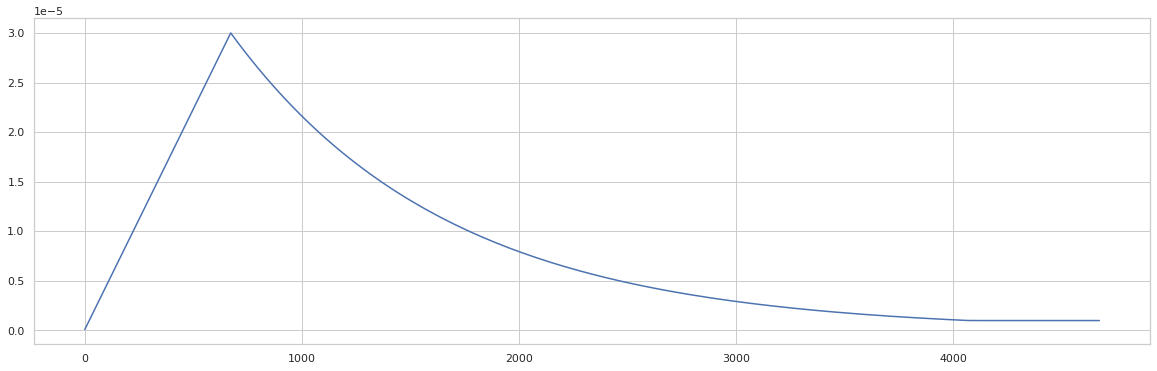

In [12]:
lr_min = 1e-6
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
warmup_steps = step_size * 1
decay = .999

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h11 = hidden_states[-2]
    
    x = layers.Dropout(.1)(h11)
    
    x_start = layers.Dense(1)(x)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    
    x_end = layers.Dense(1)(x)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [14]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))

    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=warmup_steps, lr_start=lr_start, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_end': losses.CategoricalCrossentropy(label_smoothing=0.2)})
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=False, verbose=1)
    checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        validation_steps=valid_step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold_best, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])


FOLD: 1
Epoch 1/7
672/672 - 161s - loss: 4.8544 - y_start_loss: 2.3565 - y_end_loss: 2.4978 - val_loss: 3.8906 - val_y_start_loss: 1.9518 - val_y_end_loss: 1.9388
Epoch 2/7
672/672 - 162s - loss: 3.8555 - y_start_loss: 1.9279 - y_end_loss: 1.9276 - val_loss: 3.8332 - val_y_start_loss: 1.9258 - val_y_end_loss: 1.9074
Epoch 3/7
672/672 - 162s - loss: 3.7096 - y_start_loss: 1.8615 - y_end_loss: 1.8480 - val_loss: 3.8011 - val_y_start_loss: 1.9225 - val_y_end_loss: 1.8787
Epoch 4/7
672/672 - 158s - loss: 3.6249 - y_start_loss: 1.8258 - y_end_loss: 1.7992 - val_loss: 3.8159 - val_y_start_loss: 1.9299 - val_y_end_loss: 1.8860
Epoch 5/7
672/672 - 162s - loss: 3.5746 - y_start_loss: 1.7958 - y_end_loss: 1.7787 - val_loss: 3.7980 - val_y_start_loss: 1.9213 - val_y_end_loss: 1.8767
Epoch 6/7
672/672 - 158s - loss: 3.5449 - y_start_loss: 1.7853 - y_end_loss: 1.7596 - val_loss: 3.8160 - val_y_start_loss: 1.9336 - val_y_end_loss: 1.8824
Epoch 7/7
672/672 - 158s - loss: 3.5354 - y_start_loss: 1.779

# Model loss graph

Fold: 1


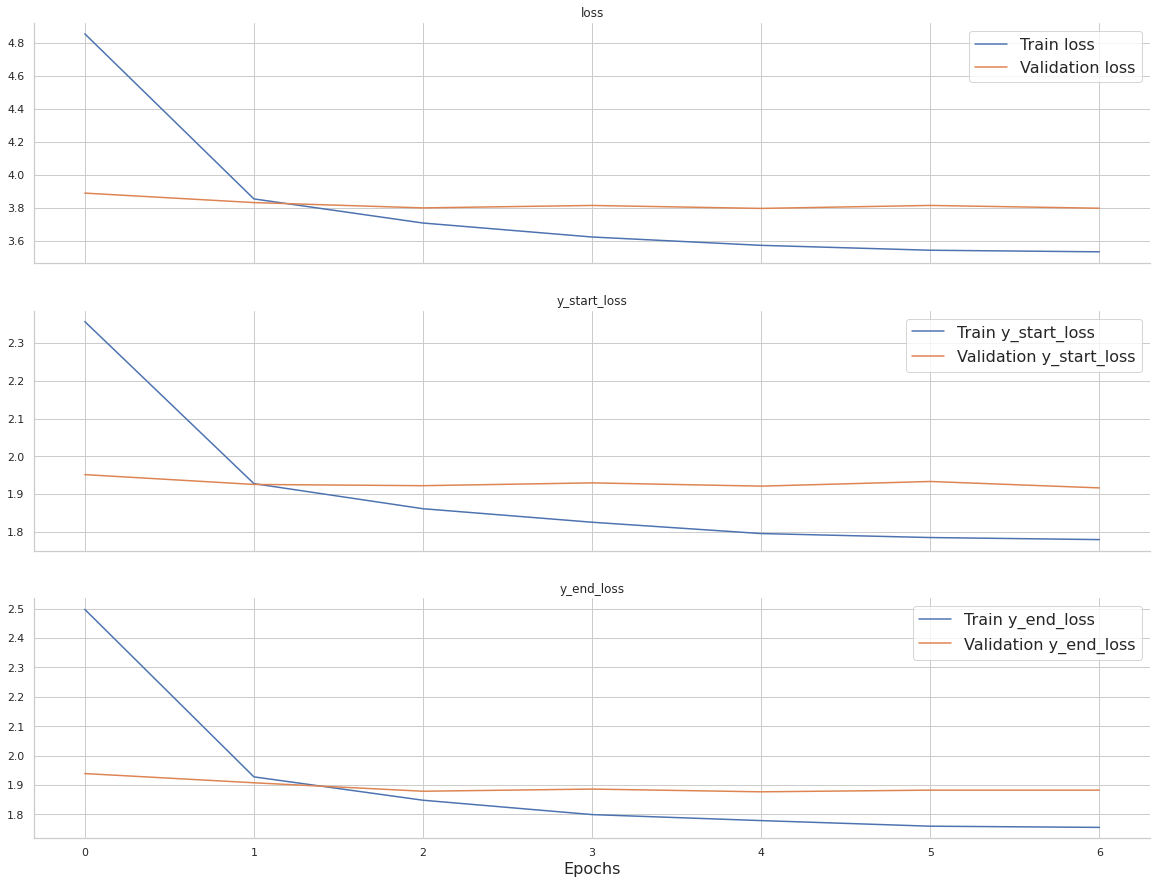

Fold: 2


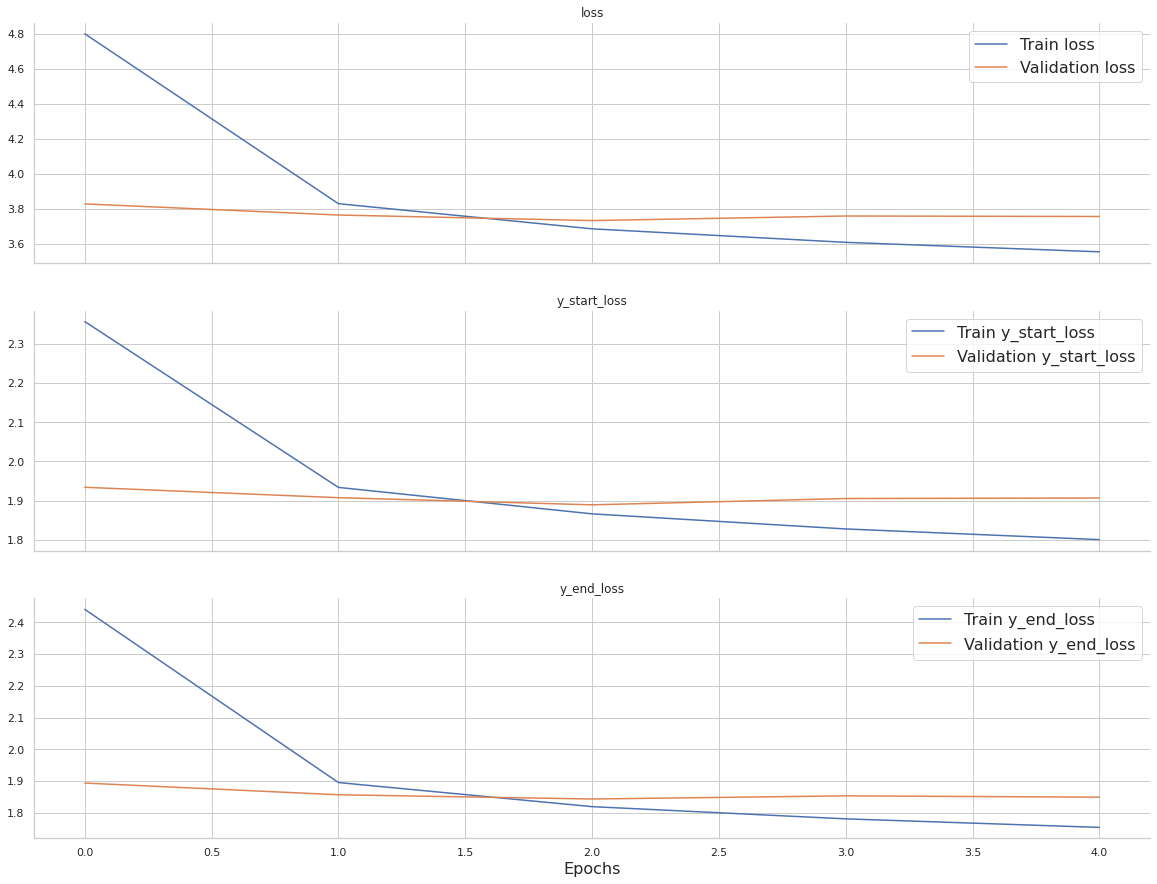

Fold: 3


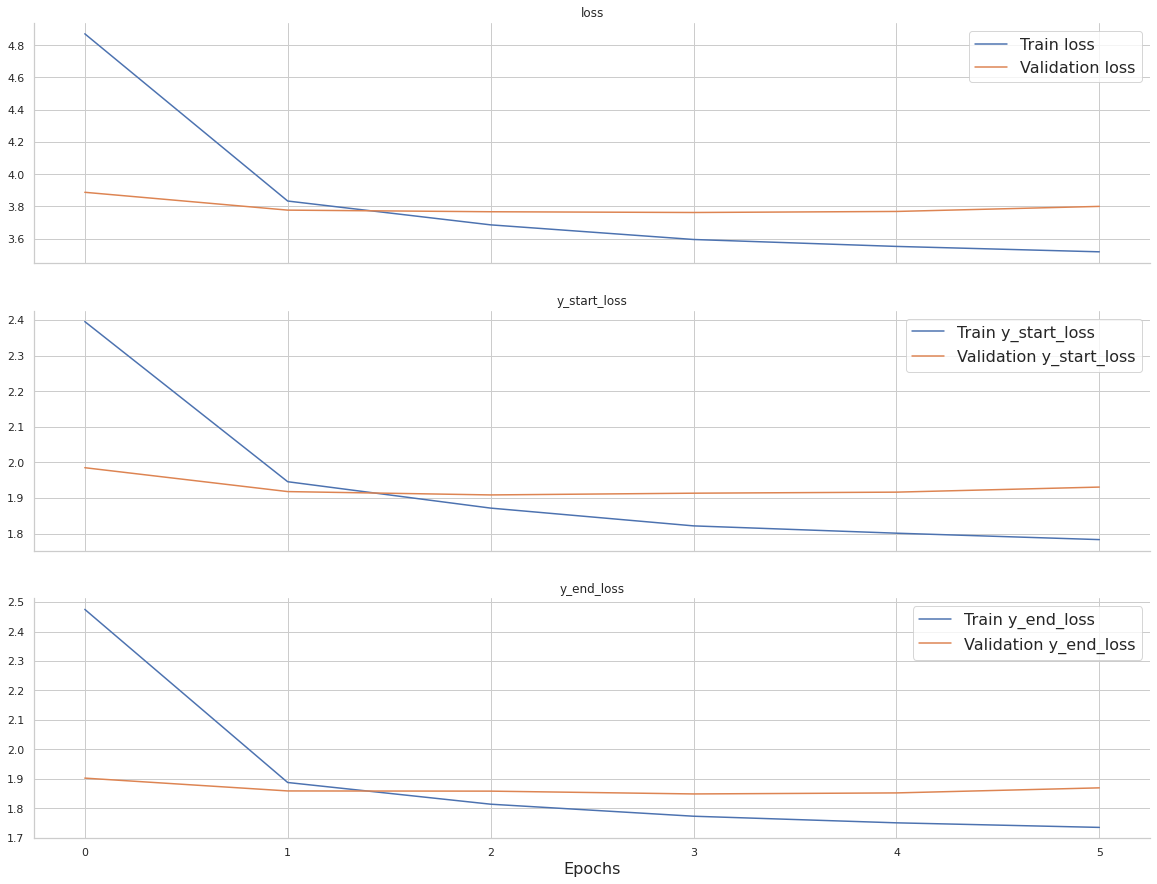

Fold: 4


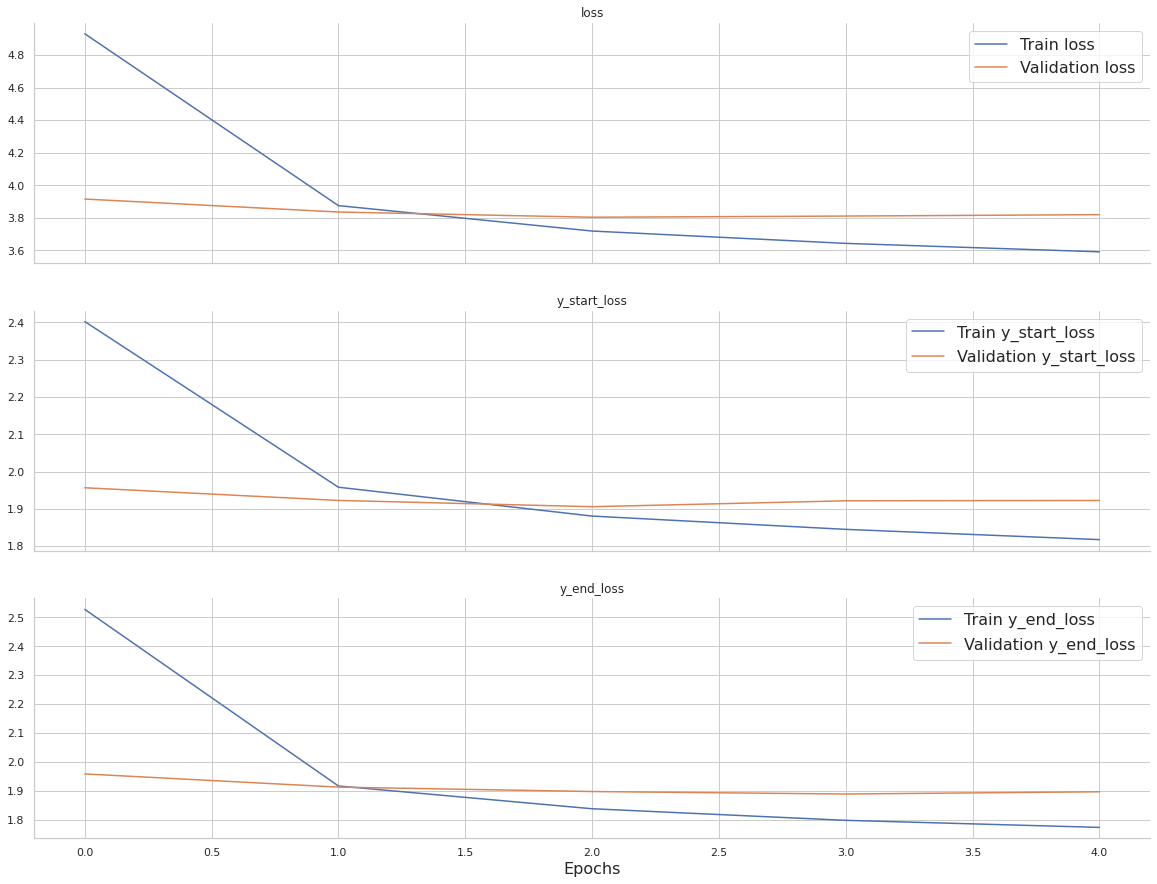

Fold: 5


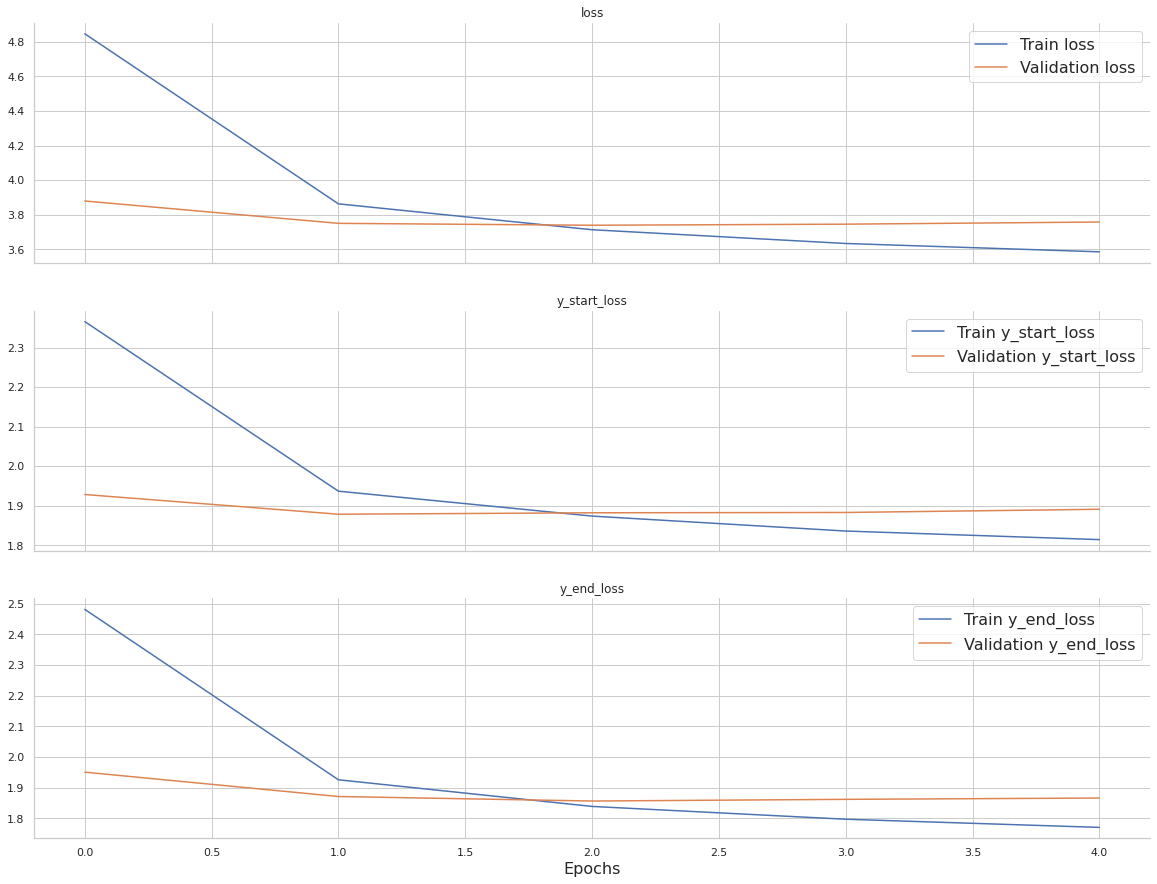

In [15]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [16]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.772706,0.723208,0.049499,0.790091,0.724111,0.765286,0.723221,0.781439,0.723999,0.761989,0.718305,0.764727,0.726403
Sentiment negative,0.636650,0.547111,0.089540,0.671559,0.533148,0.619451,0.543506,0.652915,0.561834,0.616861,0.546448,0.622465,0.550617
Sentiment neutral,0.977963,0.975702,0.002261,0.978191,0.976611,0.977819,0.976165,0.978125,0.973820,0.978002,0.973661,0.977676,0.978251
Sentiment positive,0.620860,0.544315,0.076545,0.645356,0.558750,0.612542,0.546975,0.634262,0.536060,0.603945,0.531718,0.608194,0.548071
0 <= text tokens < 3,0.961189,0.955159,0.006030,0.961712,0.961538,0.965066,0.939655,0.964435,0.979167,0.959574,0.942308,0.955157,0.953125
3 <= text tokens < 15,0.819184,0.780877,0.038307,0.829993,0.788988,0.816547,0.775075,0.823587,0.782714,0.812592,0.777377,0.813201,0.780233
15 <= text tokens < 30,0.744354,0.689279,0.055075,0.765526,0.686093,0.732501,0.691964,0.756531,0.691380,0.731939,0.677020,0.735273,0.699938
30 <= text tokens < 50,0.718818,0.652795,0.066022,0.743856,0.645390,0.712022,0.654790,0.728565,0.650741,0.701762,0.663677,0.707884,0.649378
50 <= text tokens < 120,0.905601,0.882966,0.022635,0.939286,0.947368,0.924074,0.928571,0.927832,1.000000,0.863004,0.788889,0.873810,0.750000


# Visualize predictions

In [18]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,index,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,imputed
0,0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,False
1,1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,False
2,2,my boss is bullying me...,bullying me,negative,0.166667,6,2,False
3,3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,False
4,4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,False
5,5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,False
6,6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,False
7,7,soooo high,soooo high,neutral,1.000000,3,3,False
8,8,both of you,both of you,neutral,1.000000,3,3,False
9,9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,False
